In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# data ingestion

## functions definition

In [17]:
# pd.read_excel: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
# pd.DatetimeIndex: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
# pd.DataFrame.asfreq: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

HOSTNAME_FIELD = 'Hostname'

def pull_raw_data(file_location):
    raw = pd.read_excel(file_location, None)
    return raw

def get_region_data(region, file_location):
    """
    Function for fetching region data
    :file_location: file path for data source
    :region:
        NB GA Data 1:
            NB | GA | US Data
            NB | GA | CA Data
            NB | GA | AU Data
            NB | GA | NZ Data
            NB | GA | JNBO Data
        NB GA Data 2:
            NB | GA | EU + UK
            NB | GA | TW
            NB | GA | HK
            NB | GA | MY
            NB | GA | SG
    """
    all_data = pull_raw_data(file_location)
    region_data = all_data[region]
    region_data = region_data.copy(deep=False)
    region_data['Date'] = pd.to_datetime(region_data['Date'])
    region_data.set_index('Date', inplace=True)
    region_data.index = pd.DatetimeIndex(region_data.index.values, freq=region_data.index.inferred_freq)
    asc = region_data.sort_index()
    return asc

def describe_region_data(region_data):
    return pd.Series({'devices':','.join(list(region_data['Device Category'].unique())),
                      'channels':','.join(list(region_data['Default Channel Grouping'].unique())),
                      'hostnames':','.join(list(region_data['Hostname'].unique())),
                      'start_date':region_data.index.min(),
                      'end_date':region_data.index.max()})

def get_hostname_data(hostname, region_data):
    hostname_data = region_data[region_data[HOSTNAME_FIELD] == hostname]
    return hostname_data

def apply_index_freq(data, freq):
    return data.asfreq(freq)

def aggregate_daily_data(data):
    data = data.copy(deep=False)
    data.loc[:, 'Year'] = data.index.year
    data.loc[:, 'Month'] = data.index.month
    data.loc[:, 'Day'] = 1
    data.loc[:, 'Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
    return data.groupby('Date').agg({'Sessions':'sum', 'Pageviews':'sum'})

def filter_by_date(data, left_datetime=None, right_datetime=None):
    """
    Function for filtering data not recorded by a complete month
    :left_datetime: filter data whose date is less than left_datetime
    :right_datetime: filter data whose date is greater than right_datetime
    """
    if left_datetime:
        data = data[data.index > left_datetime]
    
    if right_datetime:
        data = data[data.index < right_datetime]
    
    return data

## test

In [29]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
region_data = get_region_data('NB | GA | US Data', ts_file)
describe_region_data(region_data)

devices                                   desktop,mobile,tablet
channels      (Other),Direct,Display,Organic Search,Paid Sea...
hostnames     www.newbalance.com,www.nbls.cc,www.newbalance....
start_date                                  2016-11-30 00:00:00
end_date                                    2022-12-31 00:00:00
dtype: object

In [30]:
newbalancecom = get_hostname_data('www.newbalance.com', region_data)
newbalancecom_month = aggregate_daily_data(newbalancecom)
newbalancecom_month = apply_index_freq(newbalancecom_month, 'MS')
newbalancecom_month

,Sessions,Pageviews
Date,,
2016-11-01,141300,855724
2016-12-01,3378004,23999244
2017-01-01,3360180,21827590
2017-02-01,3269727,22854333
2017-03-01,3927370,26801491
...,...,...
2022-08-01,10958689,37023290
2022-09-01,9481649,31645979
2022-10-01,12059381,38057960


In [31]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
region_data = get_region_data('NB | GA | CA Data', ts_file)
describe_region_data(region_data)

devices                                   desktop,mobile,tablet
channels      Direct,Organic Search,Paid Search,Referral,Soc...
hostnames     www.newbalance.ca,(not set),www.bigdata-domain...
start_date                                  2016-11-30 00:00:00
end_date                                    2022-12-31 00:00:00
dtype: object

In [32]:
newbalanceca = get_hostname_data('www.newbalance.ca', region_data)
newbalanceca_month = aggregate_daily_data(newbalanceca)
newbalanceca_month = apply_index_freq(newbalanceca_month, 'MS')
newbalanceca_month

,Sessions,Pageviews
Date,,
2016-11-01,4002,31120
2016-12-01,107499,945851
2017-01-01,142985,1162558
2017-02-01,144891,1214112
2017-03-01,239750,1808862
...,...,...
2022-08-01,1121613,4362433
2022-09-01,1104203,4355085
2022-10-01,1121899,4191353


In [33]:
ts_file = '/opt/notebooks/datasets/NB_GA_Data_2.xlsx'
region_data = get_region_data('NB | GA | EU + UK', ts_file)
describe_region_data(region_data)

devices                                   desktop,mobile,tablet
channels      Email,Paid Search,Organic Search,Referral,Dire...
hostnames     at.newbalance.eu,www.newbalance.fr,www.newbala...
start_date                                  2018-09-25 00:00:00
end_date                                    2022-12-31 00:00:00
dtype: object

In [34]:
newbalancefr = get_hostname_data('www.newbalance.fr', region_data)
newbalancefr_month = aggregate_daily_data(newbalancefr)
newbalancefr_month = apply_index_freq(newbalancefr_month, 'MS')
newbalancefr_month

,Sessions,Pageviews
Date,,
2018-09-01,67388,300965
2018-10-01,289161,1467829
2018-11-01,395531,1932762
2018-12-01,292351,1402871
2019-01-01,437445,2182022
2019-02-01,304855,1546504
2019-03-01,345297,1967805
2019-04-01,427892,2198442
2019-05-01,455582,2321955


# Outlier visualization

## functions definitions

In [25]:
def generate_outlier_plots(data_series, series_name, series_column, event_date, event_name, image_name):
    """
    Function for generating outlier plot data.
    :param data_series: The timeseries series element (indexed by date) to plot
    :param series_name: A human-readable name for the time series for applying a label to the plot
    :param series_column: The name of the series column within the passed in DataFrame
    :event_date: A date specified that marks an outlier event to flag in the plot
    :event_name: An explanatory string that represents what the outlier event is to provide context in the plot
    :image_name: The name of the file to create in svg format to save the plot to local file system
    :return: the pyplot figure.
    """
    # create column names for differencing stationary functions
    log_name = f'Log {series_column}'
    month_log_name = f'DiffLog {series_column} month'
    year_log_name = f'DiffLog {series_column} year'

    # convert the passed-in event date to a date time object
    event_marker = datetime.strptime(event_date, '%Y-%m-%d').replace(day=1)

    # create boundary lines around event for visual purpose
    month_delta = relativedelta(months=2)
    event_boundary_left = event_marker - month_delta
    event_boundary_right = event_marker + month_delta

    # get the max value for y-axis so we can draw vertical componet
    max_scaling = np.round(data_series[series_column].values.max() * 1.1, 0)

    # create a deep copy (in-memory copy of original series)
    data = data_series.copy(deep=True)

    # add in the differencing columns
    data[log_name] = np.log(data[series_column])
    data[month_log_name] = data[log_name].diff(1)
    data[year_log_name] = data[log_name].diff(12)

    # generate the plot layout
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    axes[0].plot(data[series_column], '-', label=series_column)
    axes[0].set(title='{} {}'.format(series_name, series_column))
    
    # draw the vertical boundary lines (offset 2 months on either side of the passed in date)
    axes[0].axvline(event_boundary_left, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[0].axvline(event_boundary_right, 0, max_scaling, color='r', linestyle='--')
    axes[0].legend(loc='best')
    
    # plot the 1-month differenced series data and overlay the same vertical lines as axes[0] plot.
    axes[1].plot(data[month_log_name], label='Monthly diff of {}'.format(series_column))
    axes[1].hlines(0, data.index[0], data.index[-1], 'g')
    axes[1].set(title='{} Monthly diff of {}'.format(series_name, series_column))
    axes[1].axvline(event_boundary_left, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[1].axvline(event_boundary_right, 0, max_scaling, color='r', linestyle='--')
    axes[1].legend(loc='best')
    
    # plot the 12-month differenced series data.
    axes[2].plot(data[year_log_name], label='Year diff of {}'.format(series_column))
    axes[2].hlines(0, data.index[0], data.index[-1], 'g')
    axes[2].set(title='{} Yearly diff of {}'.format(series_name, series_column))
    axes[2].axvline(event_boundary_left, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[2].axvline(event_boundary_right, 0, max_scaling, color='r', linestyle='--')
    axes[2].legend(loc='best')
    
    # save the image
    plt.savefig(image_name, format='svg')
    # return the image from the function so that we can embed it in a more complex return type later
    # when we want to wrap all of these calls in a more complex execution chain.
    return fig

## test

In [23]:
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
newbalancecom = get_hostname_data('www.newbalance.com', 
                                  region_data = get_region_data('NB | GA | US Data', DATA_PATH))
newbalancecom_month = apply_index_freq(aggregate_daily_data(newbalancecom), 'MS')
newbalancecom_month = filter_by_date(newbalancecom_month, left_datetime=datetime(2016, 11, 30))

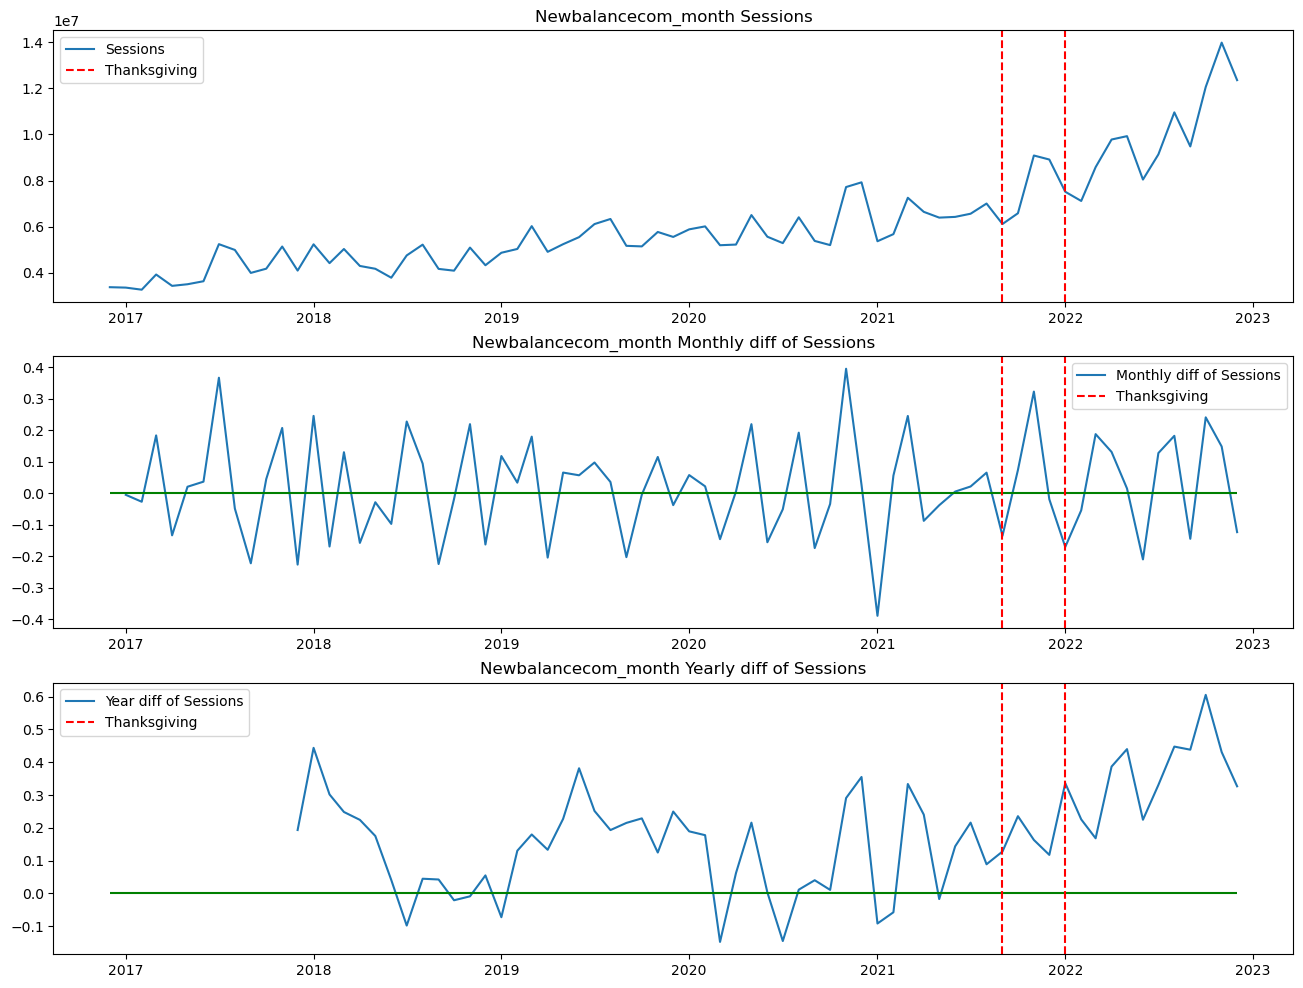

In [26]:
newbalancecom_month_outlier = generate_outlier_plots(newbalancecom_month, 
                                                     'Newbalancecom_month', 
                                                     'Sessions', 
                                                     '2021-11-01', 
                                                     'Thanksgiving', 
                                                     'NewbalancecomImpactThanksgiving.svg')

In [27]:
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
newbalanceca = get_hostname_data('www.newbalance.ca', 
                                  region_data = get_region_data('NB | GA | CA Data', DATA_PATH))
newbalanceca_month = apply_index_freq(aggregate_daily_data(newbalanceca), 'MS')
newbalanceca_month = filter_by_date(newbalanceca_month, left_datetime=datetime(2016, 11, 30))

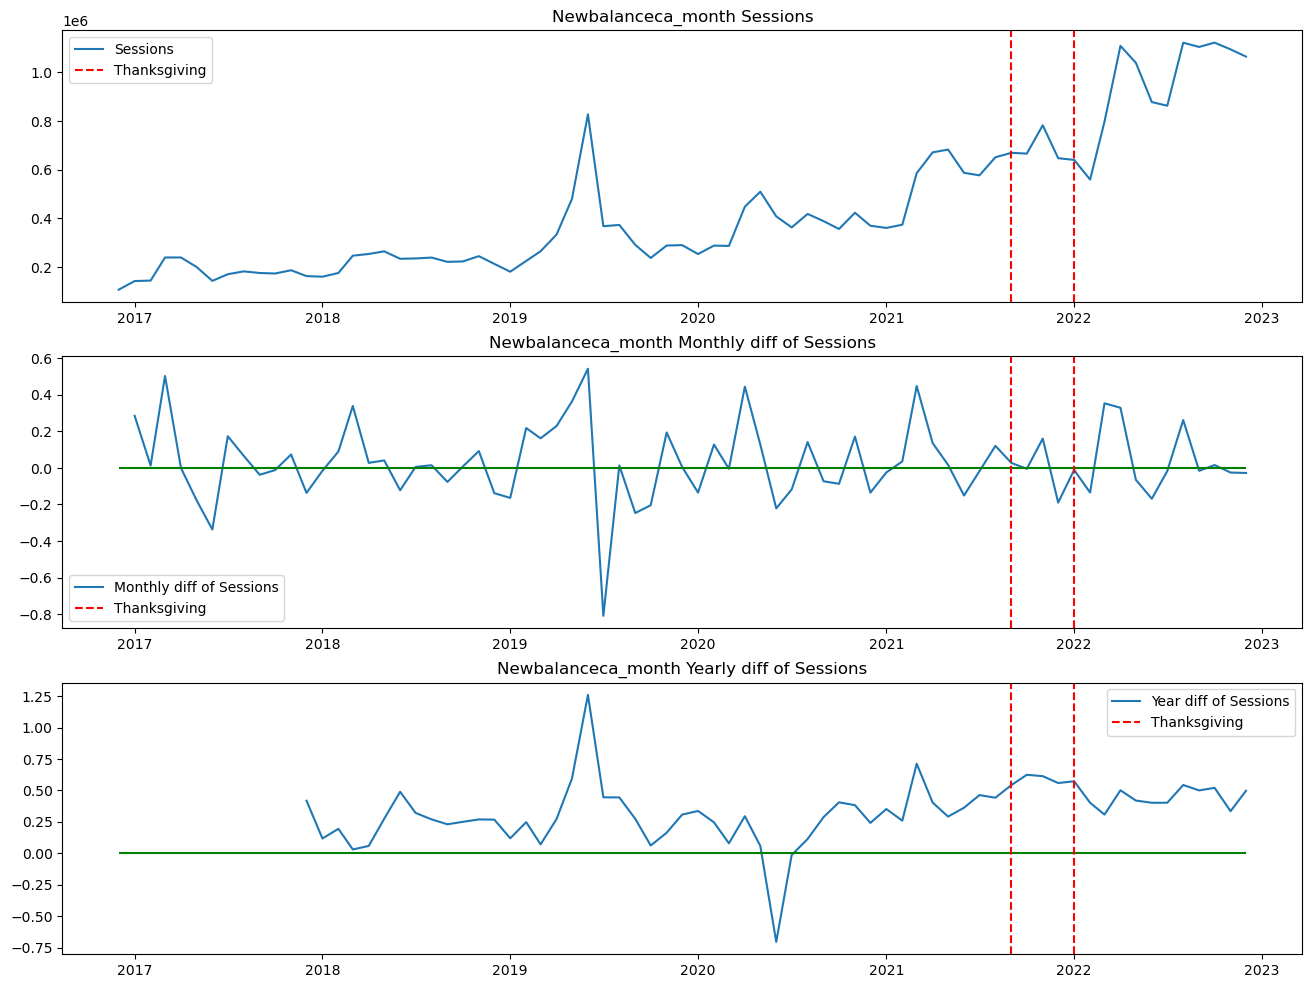

In [29]:
newbalancecom_month_outlier = generate_outlier_plots(newbalanceca_month, 
                                                     'Newbalanceca_month', 
                                                     'Sessions', 
                                                     '2021-11-01', 
                                                     'Thanksgiving', 
                                                     'NewbalancecaImpactThanksgiving.svg')

# Standard time series visualization

## functions definitions

In [39]:
def stationarity_tests(time_df, series_col, time_series_name, period, image_name, lags=12, cf_alpha=0.05, 
                       style='seaborn-v0_8', plot_size=(16, 32)):
    log_col_name = f'Log {series_col}'
    diff_log_col_name = f'LogDiff {series_col}'
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diff_log_col_name] = time_df[log_col_name].diff()
    decomposed_trend = seasonal_decompose(time_df[series_col], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    with plt.style.context(style=style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[series_col], '-', label=f'Raw data for {time_series_name}')
        axes[0].legend(loc='upper left')
        axes[0].set_title(f'Raw data trend for {time_series_name}')
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[1].plot(time_df[diff_log_col_name], 'g-', label=f'Log Diff for {time_series_name}')
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title(f'Diff Log Trend for outliers in {time_series_name}')
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        fig = plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        fig = plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[4].plot(decomposed_trend.trend, 'r-', label=f'Trend data for {time_series_name}')
        axes[4].legend(loc='upper left')
        axes[4].set_title(f'Trend component of decomposition for {time_series_name}')
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[5].plot(decomposed_trend.seasonal, 'r-', label=f'Seasonal data for {time_series_name}')
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title(f'Seasonal component of decomposition for {time_series_name}')
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[6].plot(decomposed_trend.resid, 'r.', label=f'Residuals data for {time_series_name}')
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title(f'Residuals component of decomposition for {time_series_name}')
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return fig

## test

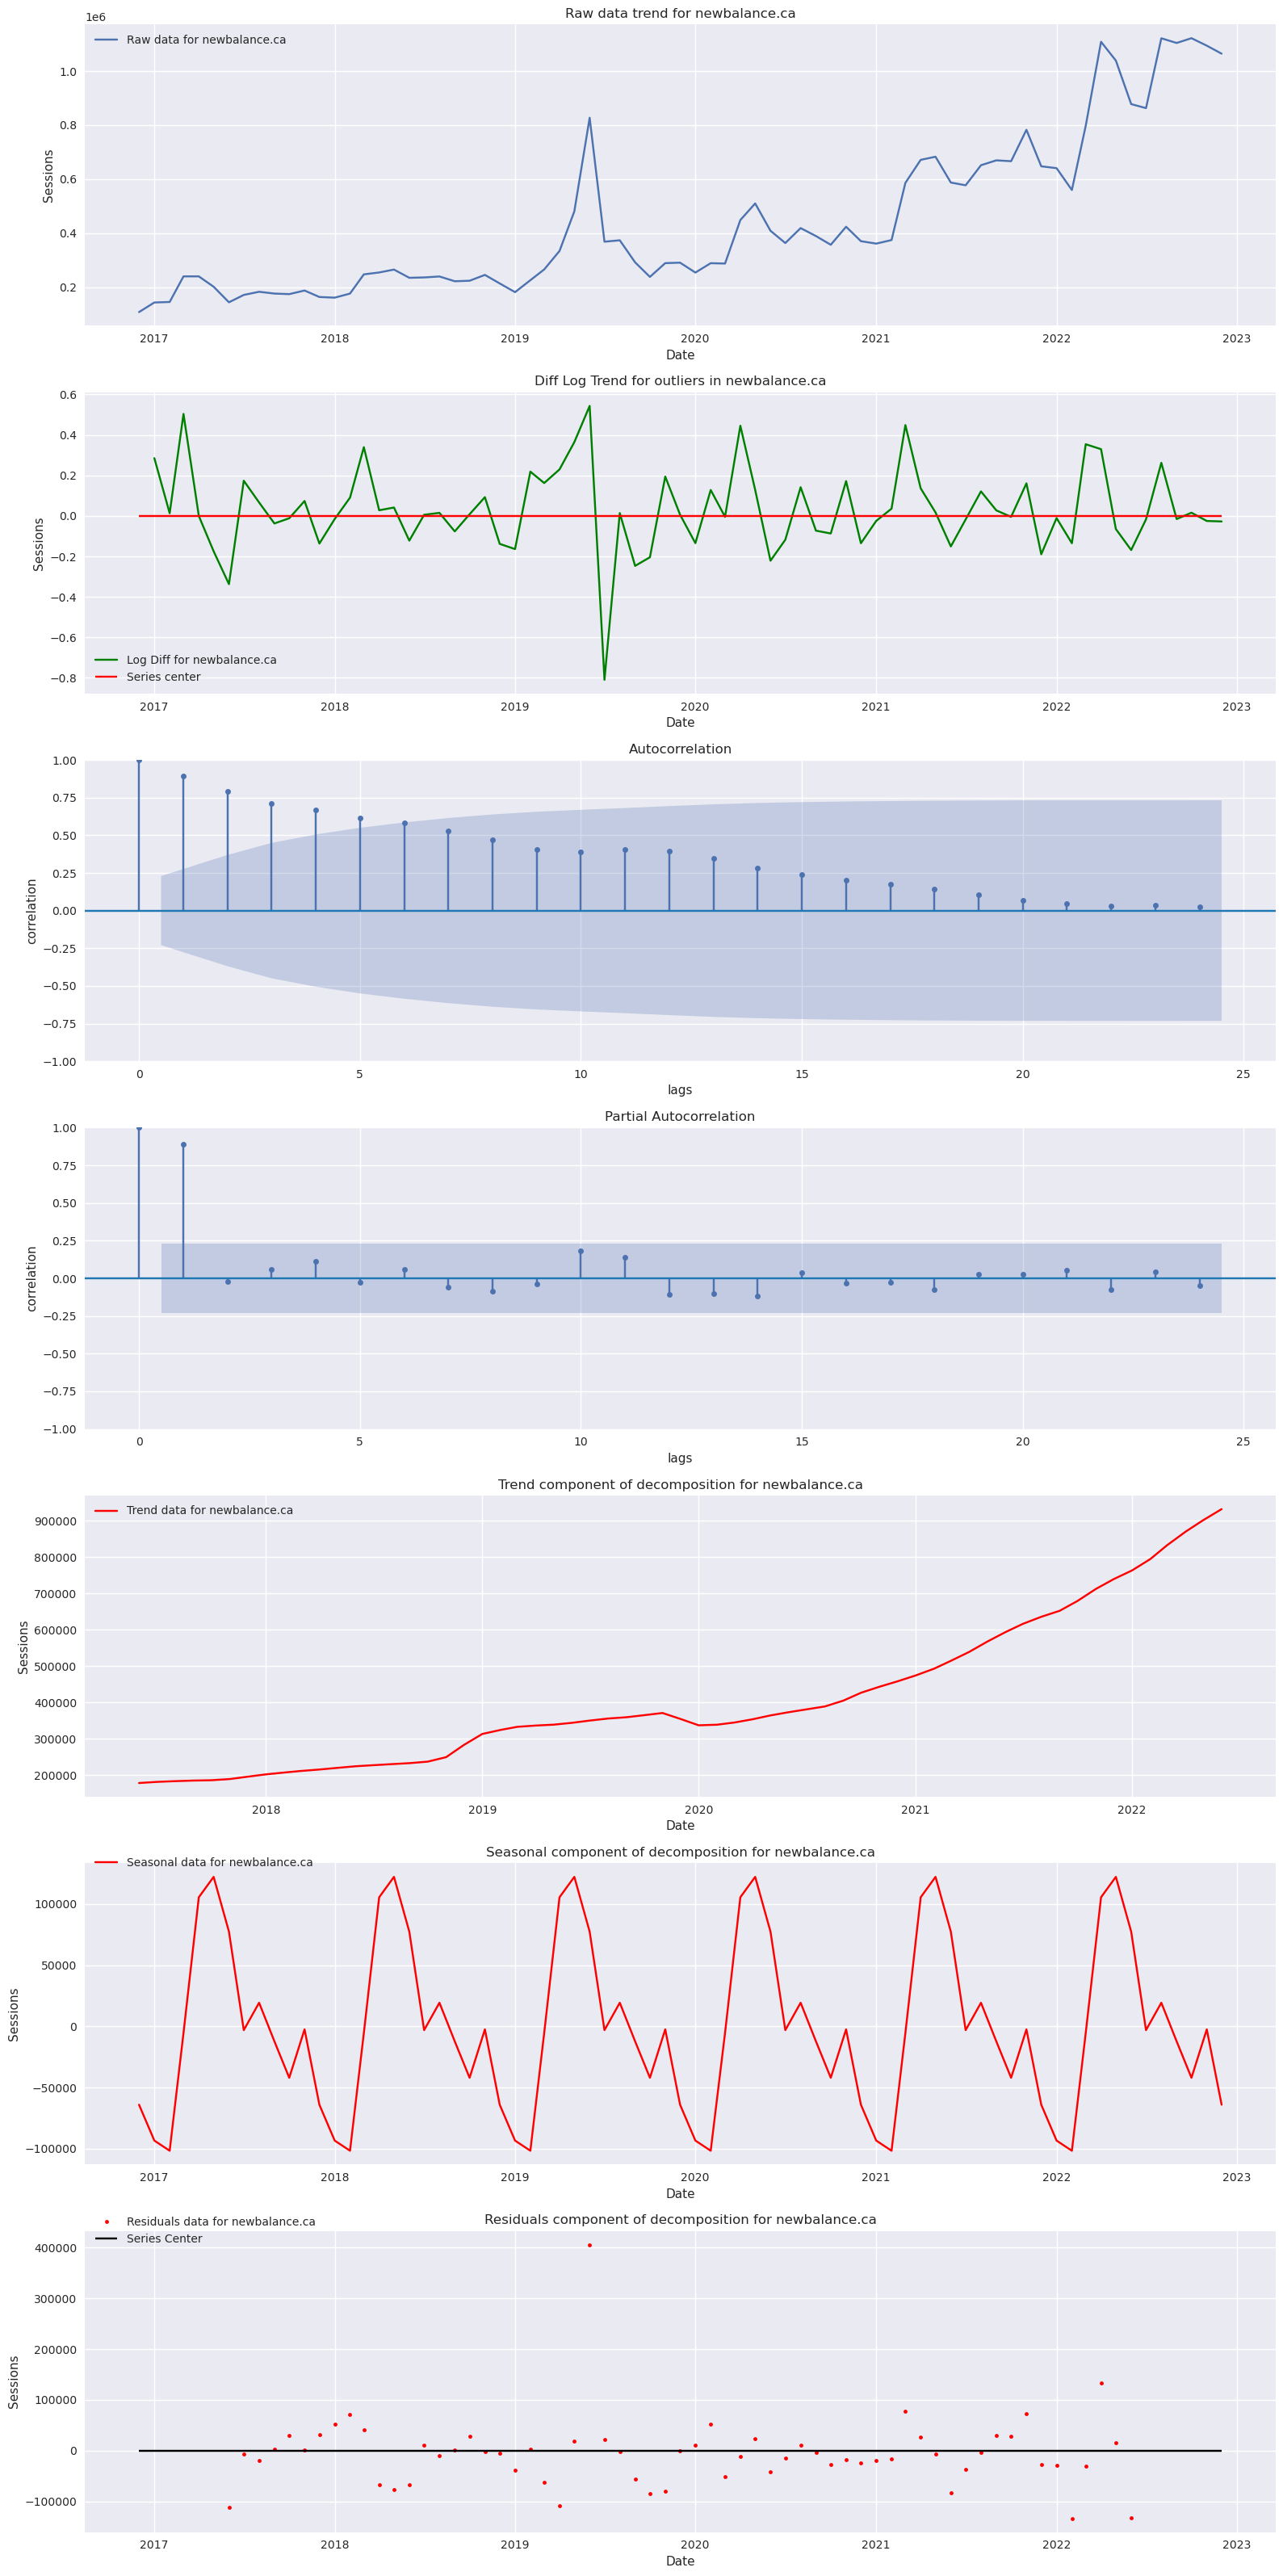

In [40]:
newbalancecom_month_stationarity_plots = stationarity_tests(newbalanceca_month, 
                                                            'Sessions', 
                                                            'newbalance.ca', 
                                                            12, 
                                                            'newbalanceca_sessions_plots.svg', 
                                                            24, 
                                                            0.05)

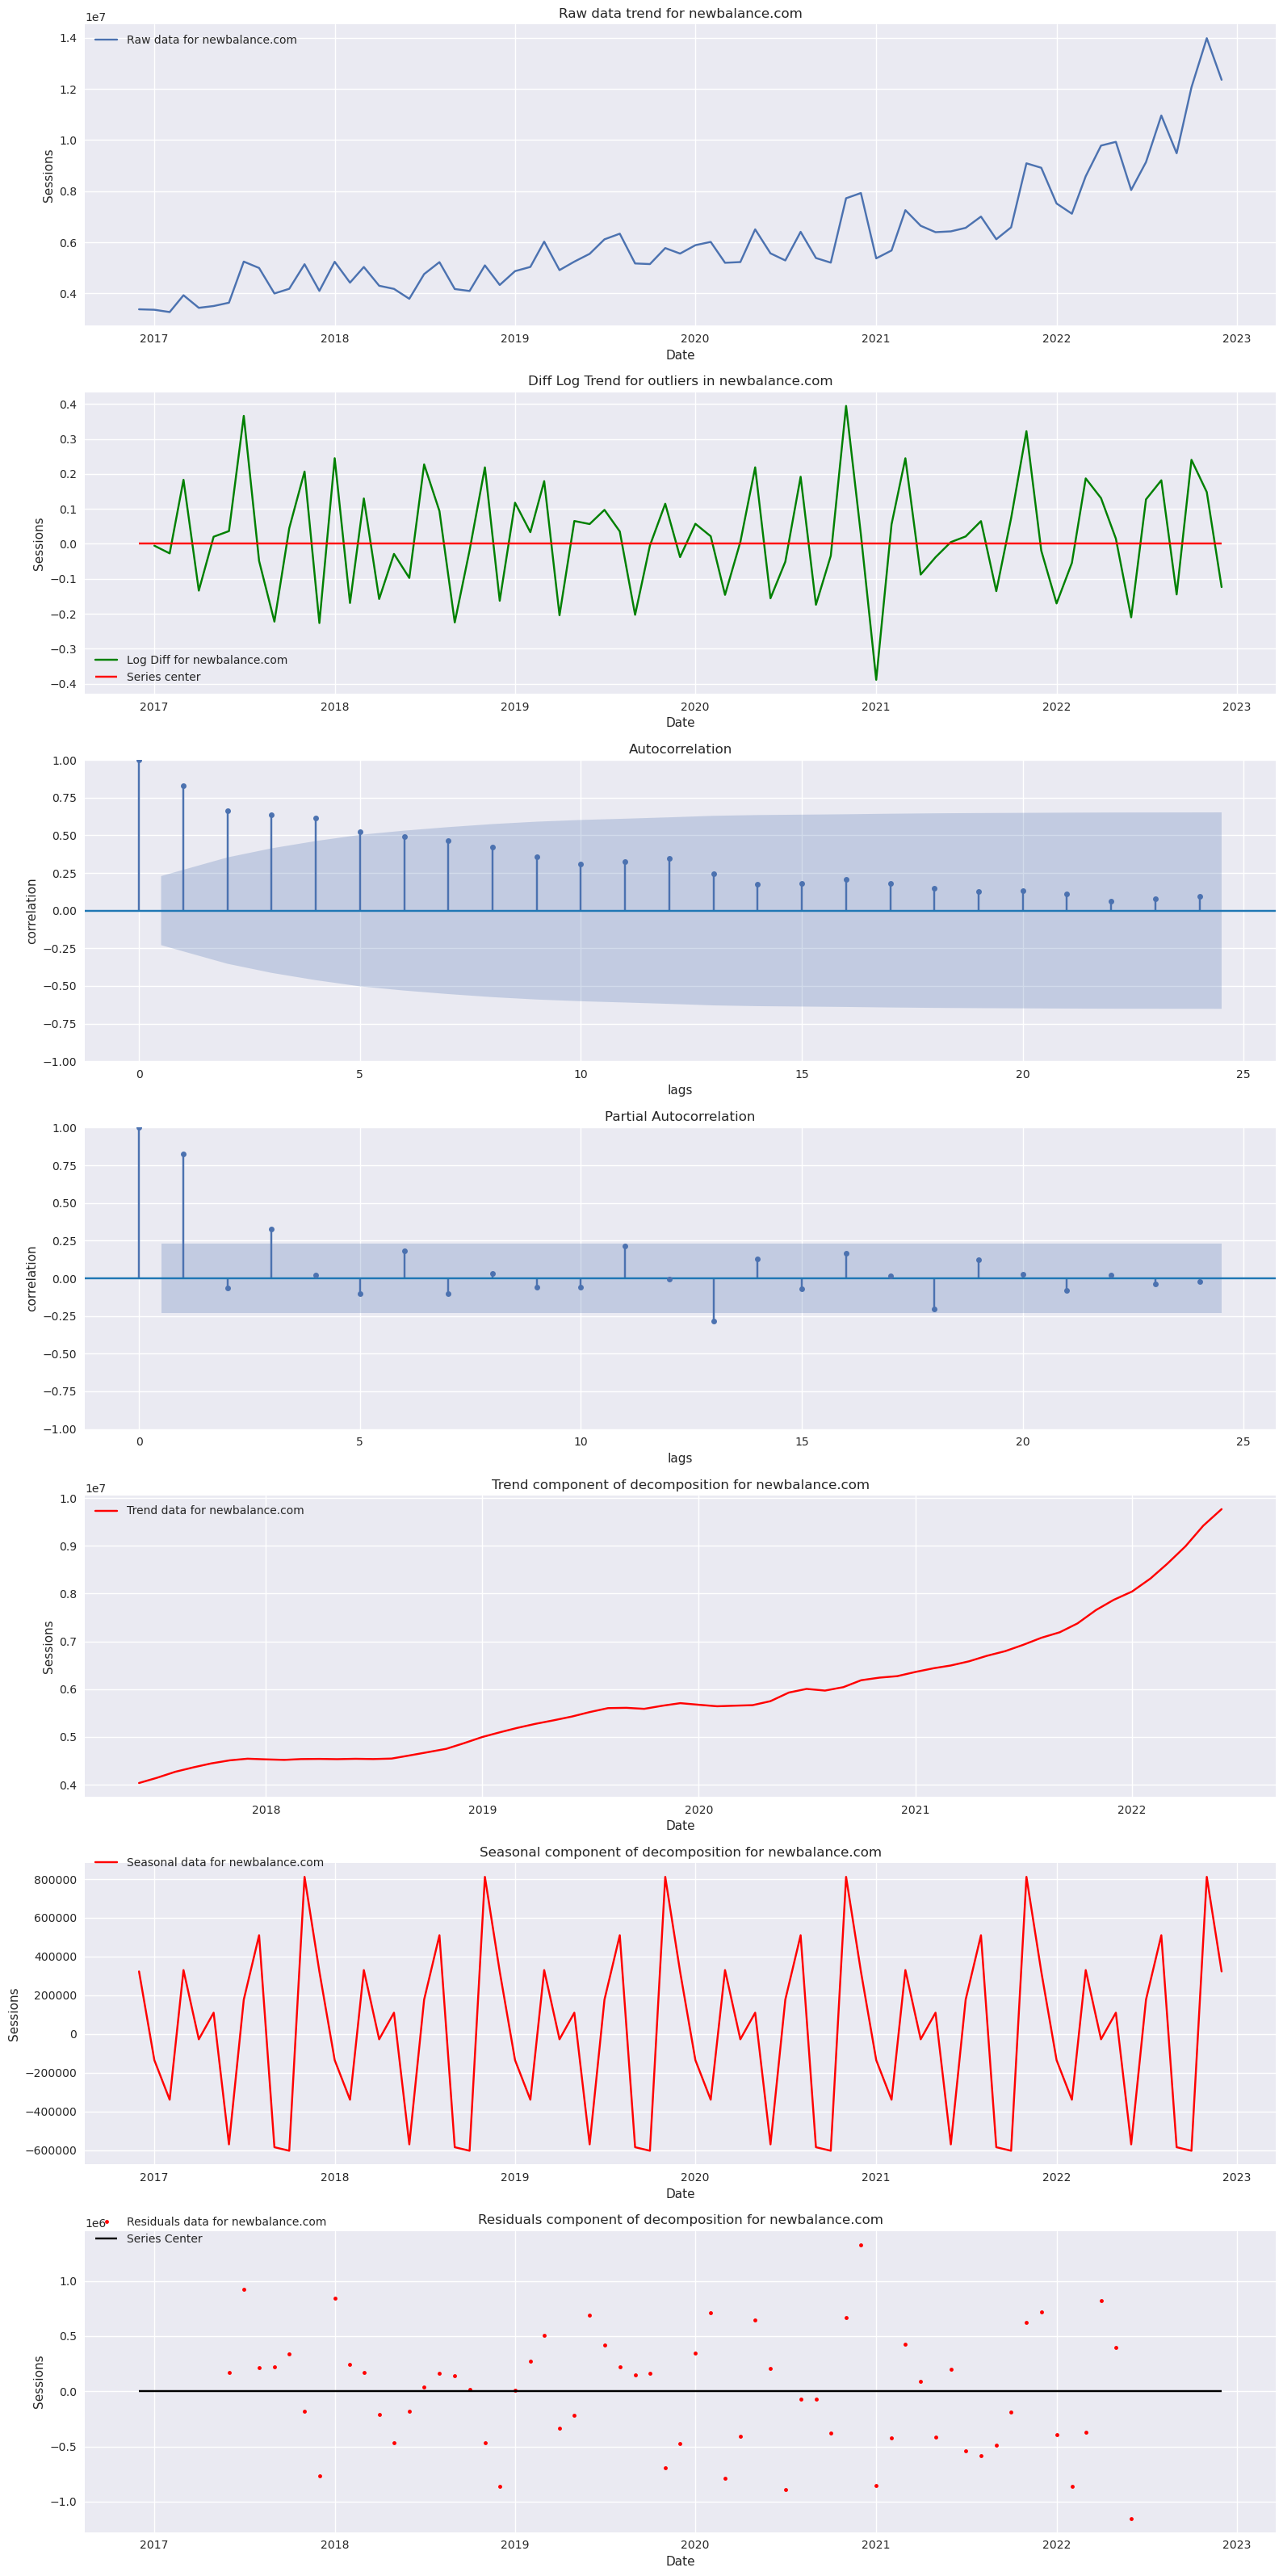

In [41]:
newbalancecom_month_stationarity_plots = stationarity_tests(newbalancecom_month, 
                                                            'Sessions', 
                                                            'newbalance.com', 
                                                            12, 
                                                            'newbalanceom_sessions_plots.svg', 
                                                            24, 
                                                            0.05)